In [10]:
import numpy as np 
import pandas as pd
from helpers import * 
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
ufc = pd.read_csv('ufc-master.csv')

# Data Loading Dock

## Ap6 + Perf Diff + drop nulls + resample 

In [11]:
feats, targ = fine_tuning_setup(ufc, one_or_two=True)

## Ap6 + Perf Cols + drop nulls + resample 

In [3]:
feats, targ = fine_tuning_setup(ufc, one_or_two=False)

## Ap6 + Ap4 + Perf Diff + drop nulls + resample 

In [9]:
AD = data_prep_and_feat_engineering(ufc, cat_thresh=0.001, squared_thresh=0.0625)
ap4_cols = AD['approach 7'][1]
target_cols = AD['approach 6'][1]

for col in ap4_cols: 
    if col not in target_cols:
        target_cols.append(col)

In [6]:

ufc, target_cols = performance_index(ufc, target_cols, diff=True)

NameError: name 'target_cols' is not defined

In [115]:
ufc = ufc.dropna(subset=target_cols)

In [116]:
feats = ufc[target_cols]

In [117]:
num, cat = num_and_cat(feats)

In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in cat:
    feats[col] = le.fit_transform(feats[col])

In [119]:
targ = [1 if victor == 'Red' else 0 for victor in ufc['Winner']]

In [120]:
r_feats, r_targ = resample_dataframe(feats, targ)

# Model Loading Dock

In [12]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

bag = BaggingClassifier(n_estimators=150)
rf = RandomForestClassifier(n_estimators=175, max_features='log2', criterion='gini')
gb = GradientBoostingClassifier(learning_rate=0.2, criterion='squared_error', max_depth=15)
hgb = HistGradientBoostingClassifier(learning_rate=0.1, max_depth=150,max_leaf_nodes=None)
extra = ExtraTreesClassifier(n_estimators=75)
lgbm = LGBMClassifier(learning_rate=0.1, num_leaves=170)
xgb = XGBClassifier(reg_lambda=1.5, learning_rate=0.25)


ml_1 = {'bag' : bag,
        'extra' : extra, 
        'rf' : rf,
        'xgb' : xgb, 
        'hgb' : hgb,
        'lgbm' : lgbm,
        'gb' : gb}

# Testing Arena

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(feats, targ, random_state=0, test_size=0.2)

In [254]:
ml_1_preds = {}

for ml in ml_1:
    model = ml_1[ml]
    model.fit(X_train, y_train)
    model_preds = model.predict(X_test)
    
    ml_1_preds[ml] = model_preds

In [255]:

final_preds = []

for i in range(len(ml_1_preds['rf'])):
    sum = 0
    for key in ml_1_preds.keys():
        sum += ml_1_preds[key][i]
    if sum > 2:
        final_preds.append(1)
    else:
        final_preds.append(0)

In [256]:
accuracy_score(final_preds, y_test)

0.7280966767371602

In [93]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

scale.fit(feats)
feats = scale.transform(feats)

In [13]:
simulate(feats, targ, ml_1)

bag
0.7205438066465257
extra
0.7084592145015106
rf
0.7265861027190332
xgb
0.6933534743202417
hgb
0.7054380664652568
[LightGBM] [Info] Number of positive: 1335, number of negative: 1313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504154 -> initscore=0.016617
[LightGBM] [Info] Start training from score 0.016617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [2]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[('lgbm', lgbm), ('rf', rf),  ('xgb', xgb), ('bag', bag)],voting='hard')

In [258]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(feats, targ, random_state=0, test_size=0.2)

vote.fit(X_train, y_train)
vote_preds = vote.predict(X_test)
accuracy_score(vote_preds, y_test)

[LightGBM] [Info] Number of positive: 1335, number of negative: 1313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504154 -> initscore=0.016617
[LightGBM] [Info] Start training from score 0.016617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

0.7371601208459214

In [294]:
precision_score(y_test, vote_preds)

0.7147435897435898

# Development Arena

In [3]:
feats.columns

Index(['B_current_win_streak', 'R_win_by_Submission',
       'B_win_by_Decision_Unanimous', 'R_win_by_Decision_Unanimous',
       'R_current_lose_streak', 'B_win_by_TKO_Doctor_Stoppage', 'win_dif',
       'B_win_by_Decision_Split', 'B_wins', 'R_Stance', 'B_age',
       'B_Weight_lbs', 'R_ev', 'B_total_rounds_fought', 'location', 'R_odds',
       'R_Reach_cms', 'R_Weight_lbs', 'R_current_win_streak', 'R_age',
       'empty_arena', 'R_win_by_Decision_Split', 'R_draw', 'lose_streak_dif',
       'B_draw', 'perf_diff'],
      dtype='object')

In [62]:
exp = feats.copy()

exp['Winner'] = targ

In [63]:
exp['B_win_by_Decision_Unanimous'].value_counts()

B_win_by_Decision_Unanimous
0     1433
1      923
2      429
3      216
4      158
5       65
6       48
7       14
8       12
10       7
9        5
Name: count, dtype: int64

In [64]:
red_win = exp[exp['Winner'] == 1]
blue_win = exp[exp['Winner'] == 0]

In [7]:
import plotly.graph_objects as go 

def red_vs_blue(df1, df2, col_name):
    
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=df1[col_name], histnorm='probability density', name='Red Win'))
    fig.add_trace(go.Histogram(x=df2[col_name], histnorm='probability density', name='Blue Win'))
    
    fig.update_layout(
    	title="Density Plot of column1 (Dataset 1) and column2 (Dataset 2)",
    	xaxis_title="Column Values",
    	yaxis_title="Density",
    	barmode='overlay'  # Overlay histograms for better comparison
	)
    
    fig.show()

In [81]:
def just_one(df1):
    
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(x=df1, histnorm='probability density', name='Red Win'))
    
    
    fig.update_layout(
    	title="Density Plot of column1 (Dataset 1) and column2 (Dataset 2)",
    	xaxis_title="Column Values",
    	yaxis_title="Density",
    	barmode='overlay'  # Overlay histograms for better comparison
	)
    
    fig.show()

In [20]:
def standardize(to_standardize):
    
    mu = np.mean(to_standardize)
    sigma = np.std(to_standardize)
    
    return [(val-mu)/sigma for val in to_standardize]
    
    

In [25]:
r_ev = list(red_win['R_ev'])
r_ev_std = standardize(r_ev)
red_win['R_std'] = r_ev_std

r_ev = list(blue_win['R_ev'])
r_ev_std = standardize(r_ev)
blue_win['R_std'] = r_ev_std

In [72]:
red_vs_blue(red_win, blue_win, 'location')

In [73]:
red_win.location.value_counts()

location
66     438
0       65
58      36
108     32
134     31
      ... 
45       1
141      1
33       1
65       1
19       1
Name: count, Length: 140, dtype: int64

In [39]:
b_rds = standardize(list(red_win['B_total_rounds_fought']))
red_win['B_total_rounds_fought'] = b_rds

In [40]:
blue_win['B_total_rounds_fought'] = standardize(list(blue_win['B_total_rounds_fought']))

In [37]:
for col in feats.columns:
    if feats[col].dtype in ['int64', 'int32']:
        print(col)
        print(len(feats[col].unique()))
        print('****************************')

B_current_win_streak
12
****************************
R_win_by_Submission
13
****************************
B_win_by_Decision_Unanimous
11
****************************
R_win_by_Decision_Unanimous
11
****************************
R_current_lose_streak
8
****************************
B_win_by_TKO_Doctor_Stoppage
3
****************************
win_dif
41
****************************
B_win_by_Decision_Split
6
****************************
B_wins
26
****************************
R_Stance
4
****************************
B_age
27
****************************
B_Weight_lbs
34
****************************
B_total_rounds_fought
82
****************************
location
144
****************************
R_Weight_lbs
32
****************************
R_current_win_streak
16
****************************
R_age
26
****************************
empty_arena
2
****************************
R_win_by_Decision_Split
6
****************************
R_draw
3
****************************
lose_streak_dif
12
******************

In [48]:
feats['B_total_rounds_fought'].value_counts()

B_total_rounds_fought
3     368
6     223
9     175
1     158
7     152
     ... 
60      1
89      1
86      1
87      1
75      1
Name: count, Length: 82, dtype: int64

In [65]:
def bin(feature_col, feature_name='B_total_rounds_fought'):
    
    to_change = list(feature_col)
    changed_col = []
    
    if feature_name == 'B_total_rounds_fought':
        
        for col in to_change:
            if col < 5:
                changed_col.append(2)
            elif col < 10:
                changed_col.append(4)
            elif col < 15: 
                changed_col.append(6)
            elif col < 20:
                changed_col.append(8)
            elif col < 25:
                changed_col.append(9)
            else:
                changed_col.append(10)
            
    
    return changed_col

In [66]:
red_win['B_total_rounds_fought'] = bin(red_win['B_total_rounds_fought'])

In [67]:
blue_win['B_total_rounds_fought'] = bin(blue_win['B_total_rounds_fought'])

In [69]:
feats['B_total_rounds_fought'] = bin(feats['B_total_rounds_fought'])

In [74]:
feats = feats.drop(['location'], axis=1)

In [80]:
corrs_list = []

for col in feats.columns:
    corrs_list.append(exp[col].corr(exp['Winner']))

In [82]:
just_one(corrs_list)

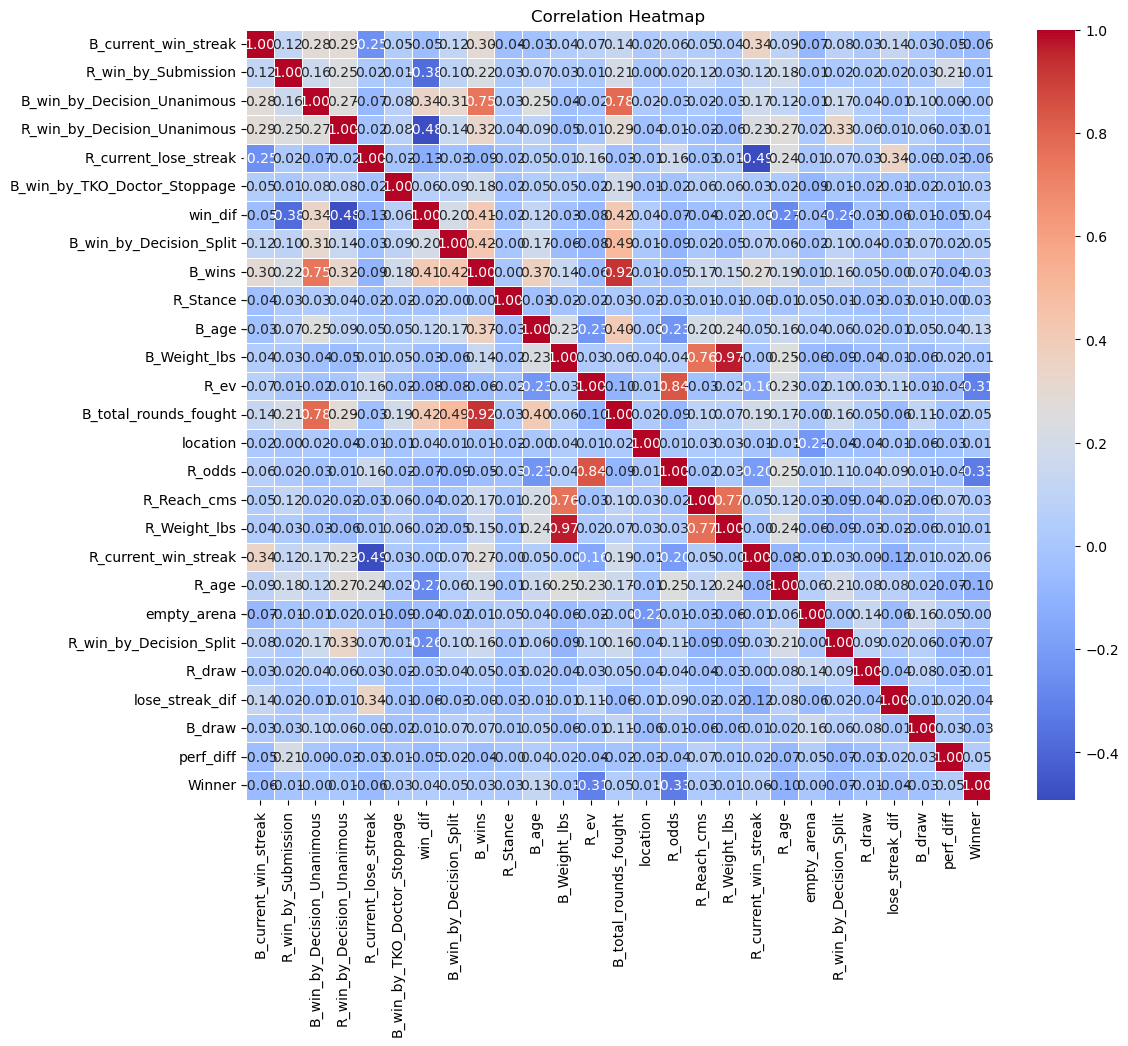

In [84]:

import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = exp.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title of the heatmap
plt.title("Correlation Heatmap")

# Show the plot
plt.show()

In [85]:
new_targets = ['R_win_by_Decision_Unanimous', 'B_win_by_Decision_Unanimous', 'B_wins', 'B_total_rounds_fought', 'R_Reach_cms', 'R_Weight_lbs', 'B_Weight_lbs', 'win_dif', 'R_current_lose_streak', 'R_current_win_streak', 'perf_diff']

In [86]:
feats = feats[new_targets]